# Importing Modules
- Torch
- Pandas
- Numpy
- PIL
- Torchmetrics

In [2]:
!pip install torchmetrics

In [3]:
import torch
import torchvision
import torchaudio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import os
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, models
from tqdm import tqdm
import torchmetrics


# Downloading Dataset from kaggle
`https://www.kaggle.com/datasets/zhangweiled/lidcidri/data`

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("zhangweiled/lidcidri")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/lidcidri


In [5]:
!cp -r "/root/.cache/kagglehub/datasets/zhangweiled/lidcidri/versions/1" /content/

# Cleaning CSV file containing mapping

In [4]:
# Loading CSV

data = pd.read_csv("/content/dataset_with_image_links.csv")
data = data[['Cancer_Label', 'Image_Link']]
data = data.dropna()
data.head()

,Cancer_Label,Image_Link
0,0,/kaggle/input/lidcidri/LIDC-IDRI-slices/LIDC-I...
1,0,/kaggle/input/lidcidri/LIDC-IDRI-slices/LIDC-I...
2,0,/kaggle/input/lidcidri/LIDC-IDRI-slices/LIDC-I...
3,0,/kaggle/input/lidcidri/LIDC-IDRI-slices/LIDC-I...
4,0,/kaggle/input/lidcidri/LIDC-IDRI-slices/LIDC-I...


In [5]:
# replacing image links with relative paths

data['Image_Link'] = data['Image_Link'].str.replace('/kaggle/input/lidcidri/LIDC-IDRI-slices/', '/content/1/LIDC-IDRI-slices/')


In [6]:
# checking count of each class (2 classes)
data.groupby("Cancer_Label").count()


,Image_Link
Cancer_Label,
0,2367
1,263


In [8]:
# transforming folder images into first level images

def process_image_links(data):
    new_data = []
    for index, row in data.iterrows():
        image_path = row['Image_Link']
        if os.path.isdir(image_path):
            for filename in os.listdir(image_path):
                if filename.endswith(('.jpg', '.jpeg', '.png')):  # Add more extensions if needed
                    image_file_path = os.path.join(image_path, filename)
                    new_data.append({'Cancer_Label': row['Cancer_Label'], 'Image_Link': image_file_path})
        else:
            if os.path.exists(image_path): # Check if the file actually exists
              new_data.append({'Cancer_Label': row['Cancer_Label'], 'Image_Link': image_path})
    return pd.DataFrame(new_data)

data = process_image_links(data)
print(data.head())
print(data.groupby("Cancer_Label").count())


   Cancer_Label                                         Image_Link
0             0  /content/1/LIDC-IDRI-slices/LIDC-IDRI-0001/nod...
1             0  /content/1/LIDC-IDRI-slices/LIDC-IDRI-0001/nod...
2             0  /content/1/LIDC-IDRI-slices/LIDC-IDRI-0001/nod...
3             0  /content/1/LIDC-IDRI-slices/LIDC-IDRI-0001/nod...
4             0  /content/1/LIDC-IDRI-slices/LIDC-IDRI-0001/nod...
              Image_Link
Cancer_Label            
0                  14107
1                   1441


In [9]:
# Balancing classes

def balance_classes(data, samples_per_class=1441):
    balanced_data = []
    for label in data['Cancer_Label'].unique():
        label_data = data[data['Cancer_Label'] == label]
        if len(label_data) > samples_per_class:
            balanced_data.append(label_data.sample(n=samples_per_class, random_state=42))  # Use random_state for reproducibility
        else:
            balanced_data.append(label_data)
    return pd.concat(balanced_data).reset_index(drop=True)

data = balance_classes(data)
print(data.groupby("Cancer_Label").count())



              Image_Link
Cancer_Label            
0                   1441
1                   1441


In [10]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import os

class LIDCDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.data.iloc[idx, 1]
        image = Image.open(img_path).convert('RGB')
        label = self.data.iloc[idx, 0]

        if self.transform:
            image = self.transform(image)

        return image, label


In [11]:
from torch.utils.data import random_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- TRANSFORMS ---
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# --- DATASET SPLIT + LOADERS ---
def get_dataloaders(data, batch_size=32):
    full_dataset = LIDCDataset(data=data, transform=None)

    train_size = int(0.7 * len(full_dataset))  # 70% train
    val_size = int(0.15 * len(full_dataset))   # 15% val
    test_size = len(full_dataset) - train_size - val_size  # 15% test

    train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

    # Set correct transforms
    train_dataset.dataset.transform = train_transform
    val_dataset.dataset.transform = val_test_transform
    test_dataset.dataset.transform = val_test_transform

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = get_dataloaders(data)

Using device: cuda


# Training Resnet18

In [14]:

# --- MODEL ---
model = models.resnet18(pretrained=True)
model.fc = nn.Sequential(
    nn.Dropout(0.8),
    nn.Linear(model.fc.in_features, 1)
)  # Binary classification
model = model.to(device)

# --- LOSS + OPTIMIZER ---
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# --- METRICS ---
train_f1 = torchmetrics.classification.BinaryF1Score().to(device)
val_f1 = torchmetrics.classification.BinaryF1Score().to(device)
test_f1 = torchmetrics.classification.BinaryF1Score().to(device)

history_train = []
history_val = []


# --- TRAIN FUNCTION ---
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    global history_train, history_val

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        train_f1.reset()

        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Training", leave=False)
        for images, labels in loop:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            preds = torch.sigmoid(outputs)
            preds_class = (preds > 0.5).float()

            correct += (preds_class == labels).sum().item()
            total += labels.size(0)

            train_f1.update(preds_class, labels)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        epoch_f1_score = train_f1.compute().item()

        history_train.append((epoch_loss, epoch_acc, epoch_f1_score))
        # --- Validation ---
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        val_f1.reset()

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Validation", leave=False):
                images = images.to(device)
                labels = labels.float().unsqueeze(1).to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()

                preds = torch.sigmoid(outputs)
                preds_class = (preds > 0.5).float()

                val_correct += (preds_class == labels).sum().item()
                val_total += labels.size(0)

                val_f1.update(preds_class, labels)

        val_epoch_loss = val_loss / len(val_loader)
        val_epoch_acc = val_correct / val_total
        val_epoch_f1_score = val_f1.compute().item()
        history_val.append((val_epoch_loss, val_epoch_acc, val_epoch_f1_score))
        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | Train F1: {epoch_f1_score:.4f} || "
              f"Val Loss: {val_epoch_loss:.4f} | Val Acc: {val_epoch_acc:.4f} | Val F1: {val_epoch_f1_score:.4f}")

# --- TEST FUNCTION ---
def test(model, test_loader):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    test_f1.reset()

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing", leave=False):
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()

            preds = torch.sigmoid(outputs)
            preds_class = (preds > 0.5).float()

            correct += (preds_class == labels).sum().item()
            total += labels.size(0)

            test_f1.update(preds_class, labels)

    test_epoch_loss = test_loss / len(test_loader)
    test_epoch_acc = correct / total
    test_epoch_f1_score = test_f1.compute().item()

    print(f"Test Results -> Loss: {test_epoch_loss:.4f} | Accuracy: {test_epoch_acc:.4f} | F1 Score: {test_epoch_f1_score:.4f}")

# --- START TRAINING ---
train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

# --- START TESTING ---
test(model, test_loader)


Epoch [1/10] | Train Loss: 0.7214 | Train Acc: 0.6242 | Train F1: 0.6156 || Val Loss: 0.6278 | Val Acc: 0.6458 | Val F1: 0.5616


Epoch [2/10] | Train Loss: 0.4367 | Train Acc: 0.7947 | Train F1: 0.7971 || Val Loss: 0.6041 | Val Acc: 0.7315 | Val F1: 0.6813


Epoch [3/10] | Train Loss: 0.2063 | Train Acc: 0.9207 | Train F1: 0.9214 || Val Loss: 0.3228 | Val Acc: 0.8565 | Val F1: 0.8714


Epoch [4/10] | Train Loss: 0.0827 | Train Acc: 0.9817 | Train F1: 0.9819 || Val Loss: 0.3477 | Val Acc: 0.8889 | Val F1: 0.8970


Epoch [5/10] | Train Loss: 0.0452 | Train Acc: 0.9931 | Train F1: 0.9931 || Val Loss: 0.4067 | Val Acc: 0.8565 | Val F1: 0.8719


Epoch [6/10] | Train Loss: 0.0398 | Train Acc: 0.9945 | Train F1: 0.9946 || Val Loss: 0.3392 | Val Acc: 0.8773 | Val F1: 0.8875


Epoch [7/10] | Train Loss: 0.0473 | Train Acc: 0.9960 | Train F1: 0.9961 || Val Loss: 0.3193 | Val Acc: 0.9051 | Val F1: 0.9126


Epoch [8/10] | Train Loss: 0.0193 | Train Acc: 0.9970 | Train F1: 0.9971 || Val Loss: 0.2964 | Val Acc: 0.8935 | Val F1: 0.9009


Epoch [9/10] | Train Loss: 0.0199 | Train Acc: 0.9950 | Train F1: 0.9951 || Val Loss: 0.3139 | Val Acc: 0.8935 | Val F1: 0.8996


Epoch [10/10] | Train Loss: 0.0407 | Train Acc: 0.9955 | Train F1: 0.9956 || Val Loss: 0.3593 | Val Acc: 0.8981 | Val F1: 0.9009


Test Results -> Loss: 0.3076 | Accuracy: 0.8961 | F1 Score: 0.8800


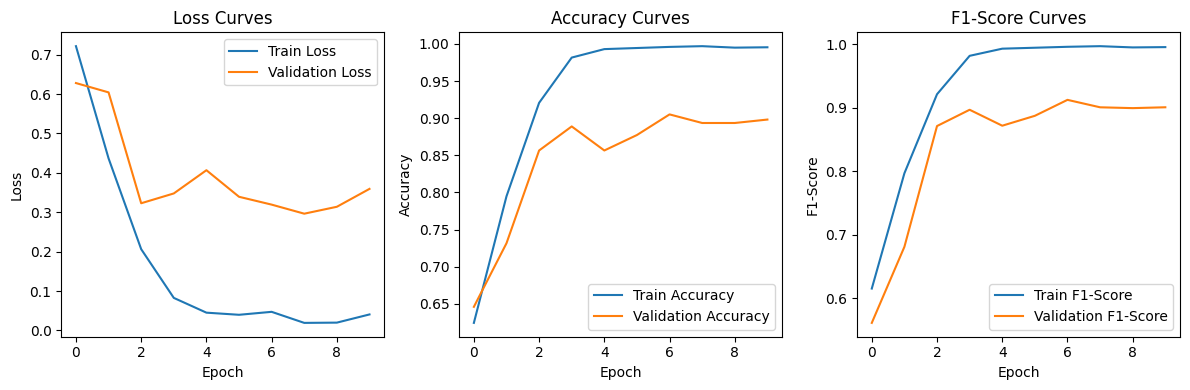

In [15]:
import matplotlib.pyplot as plt

# Assuming history_train and history_val are lists of tuples (loss, accuracy, f1_score)
train_losses, train_accuracies, train_f1s = zip(*history_train)
val_losses, val_accuracies, val_f1s = zip(*history_val)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(train_f1s, label='Train F1-Score')
plt.plot(val_f1s, label='Validation F1-Score')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('F1-Score Curves')
plt.legend()

plt.tight_layout()
plt.show()


In [16]:

# --- MODEL ---
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, 1)  # Binary classification
model = model.to(device)

# --- LOSS + OPTIMIZER ---
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# --- METRICS ---
train_f1 = torchmetrics.classification.BinaryF1Score().to(device)
val_f1 = torchmetrics.classification.BinaryF1Score().to(device)
test_f1 = torchmetrics.classification.BinaryF1Score().to(device)

history_train = []
history_val = []


# --- TRAIN FUNCTION ---
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    global history_train, history_val

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        train_f1.reset()

        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Training", leave=False)
        for images, labels in loop:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            preds = torch.sigmoid(outputs)
            preds_class = (preds > 0.5).float()

            correct += (preds_class == labels).sum().item()
            total += labels.size(0)

            train_f1.update(preds_class, labels)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        epoch_f1_score = train_f1.compute().item()

        history_train.append((epoch_loss, epoch_acc, epoch_f1_score))
        # --- Validation ---
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        val_f1.reset()

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Validation", leave=False):
                images = images.to(device)
                labels = labels.float().unsqueeze(1).to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()

                preds = torch.sigmoid(outputs)
                preds_class = (preds > 0.5).float()

                val_correct += (preds_class == labels).sum().item()
                val_total += labels.size(0)

                val_f1.update(preds_class, labels)

        val_epoch_loss = val_loss / len(val_loader)
        val_epoch_acc = val_correct / val_total
        val_epoch_f1_score = val_f1.compute().item()
        history_val.append((val_epoch_loss, val_epoch_acc, val_epoch_f1_score))
        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | Train F1: {epoch_f1_score:.4f} || "
              f"Val Loss: {val_epoch_loss:.4f} | Val Acc: {val_epoch_acc:.4f} | Val F1: {val_epoch_f1_score:.4f}")

# --- TEST FUNCTION ---
def test(model, test_loader):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    test_f1.reset()

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing", leave=False):
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()

            preds = torch.sigmoid(outputs)
            preds_class = (preds > 0.5).float()

            correct += (preds_class == labels).sum().item()
            total += labels.size(0)

            test_f1.update(preds_class, labels)

    test_epoch_loss = test_loss / len(test_loader)
    test_epoch_acc = correct / total
    test_epoch_f1_score = test_f1.compute().item()

    print(f"Test Results -> Loss: {test_epoch_loss:.4f} | Accuracy: {test_epoch_acc:.4f} | F1 Score: {test_epoch_f1_score:.4f}")

# --- START TRAINING ---
train(model, train_loader, val_loader, criterion, optimizer, num_epochs=20)

# --- START TESTING ---
test(model, test_loader)


Epoch [1/20] | Train Loss: 0.7063 | Train Acc: 0.5077 | Train F1: 0.5336 || Val Loss: 0.7118 | Val Acc: 0.5069 | Val F1: 0.4468


Epoch [2/20] | Train Loss: 0.6939 | Train Acc: 0.5270 | Train F1: 0.5427 || Val Loss: 0.6774 | Val Acc: 0.5718 | Val F1: 0.6154


Epoch [3/20] | Train Loss: 0.6851 | Train Acc: 0.5533 | Train F1: 0.5891 || Val Loss: 0.6668 | Val Acc: 0.6111 | Val F1: 0.6395


Epoch [4/20] | Train Loss: 0.6788 | Train Acc: 0.5741 | Train F1: 0.6157 || Val Loss: 0.6578 | Val Acc: 0.6366 | Val F1: 0.6638


Epoch [5/20] | Train Loss: 0.6703 | Train Acc: 0.5944 | Train F1: 0.5986 || Val Loss: 0.6533 | Val Acc: 0.6366 | Val F1: 0.6652


Epoch [6/20] | Train Loss: 0.6623 | Train Acc: 0.6123 | Train F1: 0.6455 || Val Loss: 0.6435 | Val Acc: 0.6620 | Val F1: 0.6712


Epoch [7/20] | Train Loss: 0.6567 | Train Acc: 0.6316 | Train F1: 0.6667 || Val Loss: 0.6392 | Val Acc: 0.6481 | Val F1: 0.6346


Epoch [8/20] | Train Loss: 0.6537 | Train Acc: 0.6237 | Train F1: 0.6391 || Val Loss: 0.6386 | Val Acc: 0.6528 | Val F1: 0.6560


Epoch [9/20] | Train Loss: 0.6457 | Train Acc: 0.6440 | Train F1: 0.6581 || Val Loss: 0.6291 | Val Acc: 0.6574 | Val F1: 0.6442


Epoch [10/20] | Train Loss: 0.6420 | Train Acc: 0.6455 | Train F1: 0.6642 || Val Loss: 0.6185 | Val Acc: 0.6806 | Val F1: 0.6974


Epoch [11/20] | Train Loss: 0.6421 | Train Acc: 0.6356 | Train F1: 0.6599 || Val Loss: 0.6147 | Val Acc: 0.6829 | Val F1: 0.7028


Epoch [12/20] | Train Loss: 0.6335 | Train Acc: 0.6604 | Train F1: 0.6644 || Val Loss: 0.6176 | Val Acc: 0.6528 | Val F1: 0.6795


Epoch [13/20] | Train Loss: 0.6303 | Train Acc: 0.6445 | Train F1: 0.6381 || Val Loss: 0.6068 | Val Acc: 0.6597 | Val F1: 0.6994


Epoch [14/20] | Train Loss: 0.6319 | Train Acc: 0.6495 | Train F1: 0.6761 || Val Loss: 0.6050 | Val Acc: 0.6852 | Val F1: 0.6951


Epoch [15/20] | Train Loss: 0.6290 | Train Acc: 0.6619 | Train F1: 0.6840 || Val Loss: 0.6023 | Val Acc: 0.6759 | Val F1: 0.7189


Epoch [16/20] | Train Loss: 0.6240 | Train Acc: 0.6579 | Train F1: 0.6601 || Val Loss: 0.5988 | Val Acc: 0.6806 | Val F1: 0.6947


Epoch [17/20] | Train Loss: 0.6235 | Train Acc: 0.6668 | Train F1: 0.6616 || Val Loss: 0.5949 | Val Acc: 0.6782 | Val F1: 0.7011


Epoch [18/20] | Train Loss: 0.6169 | Train Acc: 0.6673 | Train F1: 0.6836 || Val Loss: 0.5958 | Val Acc: 0.6713 | Val F1: 0.7183


Epoch [19/20] | Train Loss: 0.6169 | Train Acc: 0.6782 | Train F1: 0.6954 || Val Loss: 0.5919 | Val Acc: 0.6782 | Val F1: 0.7061


Epoch [20/20] | Train Loss: 0.6177 | Train Acc: 0.6629 | Train F1: 0.6783 || Val Loss: 0.5915 | Val Acc: 0.6991 | Val F1: 0.7072


Test Results -> Loss: 0.6206 | Accuracy: 0.6559 | F1 Score: 0.6209


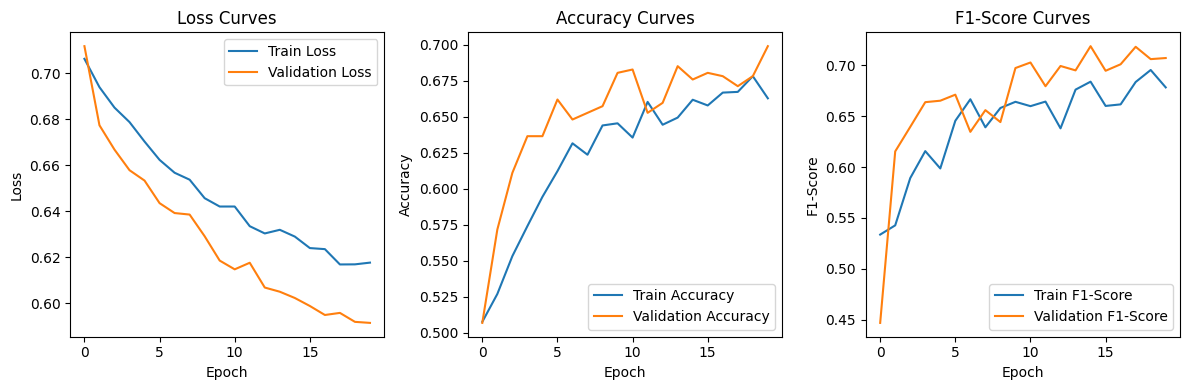

In [17]:
import matplotlib.pyplot as plt

# Assuming history_train and history_val are lists of tuples (loss, accuracy, f1_score)
train_losses, train_accuracies, train_f1s = zip(*history_train)
val_losses, val_accuracies, val_f1s = zip(*history_val)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(train_f1s, label='Train F1-Score')
plt.plot(val_f1s, label='Validation F1-Score')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('F1-Score Curves')
plt.legend()

plt.tight_layout()
plt.show()


#  EfficientNet

In [18]:
model = models.efficientnet_b0(pretrained=True)  # Or efficientnet_b1/b2 if you want larger

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace classifier
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)
model = model.to(device)


# --- LOSS + OPTIMIZER ---
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# --- METRICS ---
train_f1 = torchmetrics.classification.BinaryF1Score().to(device)
val_f1 = torchmetrics.classification.BinaryF1Score().to(device)
test_f1 = torchmetrics.classification.BinaryF1Score().to(device)

history_train = []
history_val = []


# --- TRAIN FUNCTION ---
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    global history_train, history_val

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        train_f1.reset()

        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Training", leave=False)
        for images, labels in loop:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            preds = torch.sigmoid(outputs)
            preds_class = (preds > 0.5).float()

            correct += (preds_class == labels).sum().item()
            total += labels.size(0)

            train_f1.update(preds_class, labels)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        epoch_f1_score = train_f1.compute().item()

        history_train.append((epoch_loss, epoch_acc, epoch_f1_score))
        # --- Validation ---
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        val_f1.reset()

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Validation", leave=False):
                images = images.to(device)
                labels = labels.float().unsqueeze(1).to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()

                preds = torch.sigmoid(outputs)
                preds_class = (preds > 0.5).float()

                val_correct += (preds_class == labels).sum().item()
                val_total += labels.size(0)

                val_f1.update(preds_class, labels)

        val_epoch_loss = val_loss / len(val_loader)
        val_epoch_acc = val_correct / val_total
        val_epoch_f1_score = val_f1.compute().item()
        history_val.append((val_epoch_loss, val_epoch_acc, val_epoch_f1_score))
        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | Train F1: {epoch_f1_score:.4f} || "
              f"Val Loss: {val_epoch_loss:.4f} | Val Acc: {val_epoch_acc:.4f} | Val F1: {val_epoch_f1_score:.4f}")

# --- TEST FUNCTION ---
def test(model, test_loader):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    test_f1.reset()

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing", leave=False):
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()

            preds = torch.sigmoid(outputs)
            preds_class = (preds > 0.5).float()

            correct += (preds_class == labels).sum().item()
            total += labels.size(0)

            test_f1.update(preds_class, labels)

    test_epoch_loss = test_loss / len(test_loader)
    test_epoch_acc = correct / total
    test_epoch_f1_score = test_f1.compute().item()

    print(f"Test Results -> Loss: {test_epoch_loss:.4f} | Accuracy: {test_epoch_acc:.4f} | F1 Score: {test_epoch_f1_score:.4f}")

# --- START TRAINING ---
train(model, train_loader, val_loader, criterion, optimizer, num_epochs=20)

# --- START TESTING ---
test(model, test_loader)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 116MB/s] 


Epoch [1/20] | Train Loss: 0.6940 | Train Acc: 0.5166 | Train F1: 0.6048 || Val Loss: 0.6815 | Val Acc: 0.5741 | Val F1: 0.6230


Epoch [2/20] | Train Loss: 0.6834 | Train Acc: 0.5508 | Train F1: 0.6364 || Val Loss: 0.6621 | Val Acc: 0.6204 | Val F1: 0.6996


Epoch [3/20] | Train Loss: 0.6805 | Train Acc: 0.5726 | Train F1: 0.6579 || Val Loss: 0.6561 | Val Acc: 0.6597 | Val F1: 0.7066


Epoch [4/20] | Train Loss: 0.6695 | Train Acc: 0.5959 | Train F1: 0.6373 || Val Loss: 0.6463 | Val Acc: 0.6528 | Val F1: 0.7047


Epoch [5/20] | Train Loss: 0.6641 | Train Acc: 0.6123 | Train F1: 0.6739 || Val Loss: 0.6407 | Val Acc: 0.6690 | Val F1: 0.7179


Epoch [6/20] | Train Loss: 0.6548 | Train Acc: 0.6346 | Train F1: 0.6846 || Val Loss: 0.6347 | Val Acc: 0.6829 | Val F1: 0.7308


Epoch [7/20] | Train Loss: 0.6496 | Train Acc: 0.6425 | Train F1: 0.6697 || Val Loss: 0.6289 | Val Acc: 0.6736 | Val F1: 0.7117


Epoch [8/20] | Train Loss: 0.6410 | Train Acc: 0.6490 | Train F1: 0.6764 || Val Loss: 0.6265 | Val Acc: 0.6991 | Val F1: 0.7162


Epoch [9/20] | Train Loss: 0.6378 | Train Acc: 0.6534 | Train F1: 0.6844 || Val Loss: 0.6193 | Val Acc: 0.6852 | Val F1: 0.7004


Epoch [10/20] | Train Loss: 0.6306 | Train Acc: 0.6614 | Train F1: 0.6993 || Val Loss: 0.6110 | Val Acc: 0.6852 | Val F1: 0.7155


Epoch [11/20] | Train Loss: 0.6253 | Train Acc: 0.6817 | Train F1: 0.7066 || Val Loss: 0.6108 | Val Acc: 0.6898 | Val F1: 0.7161


Epoch [12/20] | Train Loss: 0.6202 | Train Acc: 0.6802 | Train F1: 0.7059 || Val Loss: 0.6198 | Val Acc: 0.6875 | Val F1: 0.7007


Epoch [13/20] | Train Loss: 0.6215 | Train Acc: 0.6663 | Train F1: 0.6942 || Val Loss: 0.6073 | Val Acc: 0.6944 | Val F1: 0.7105


Epoch [14/20] | Train Loss: 0.6130 | Train Acc: 0.6896 | Train F1: 0.7099 || Val Loss: 0.5981 | Val Acc: 0.7153 | Val F1: 0.7411


Epoch [15/20] | Train Loss: 0.6160 | Train Acc: 0.6862 | Train F1: 0.6961 || Val Loss: 0.5987 | Val Acc: 0.7060 | Val F1: 0.7184


Epoch [16/20] | Train Loss: 0.6085 | Train Acc: 0.6857 | Train F1: 0.7076 || Val Loss: 0.5939 | Val Acc: 0.7199 | Val F1: 0.7364


Epoch [17/20] | Train Loss: 0.6083 | Train Acc: 0.6787 | Train F1: 0.6986 || Val Loss: 0.5926 | Val Acc: 0.7037 | Val F1: 0.7253


Epoch [18/20] | Train Loss: 0.6039 | Train Acc: 0.6991 | Train F1: 0.7157 || Val Loss: 0.5904 | Val Acc: 0.6968 | Val F1: 0.7056


Epoch [19/20] | Train Loss: 0.5995 | Train Acc: 0.7015 | Train F1: 0.7163 || Val Loss: 0.5845 | Val Acc: 0.7083 | Val F1: 0.7212


Epoch [20/20] | Train Loss: 0.6061 | Train Acc: 0.6812 | Train F1: 0.6968 || Val Loss: 0.5858 | Val Acc: 0.7222 | Val F1: 0.7285


Test Results -> Loss: 0.6175 | Accuracy: 0.6651 | F1 Score: 0.6214


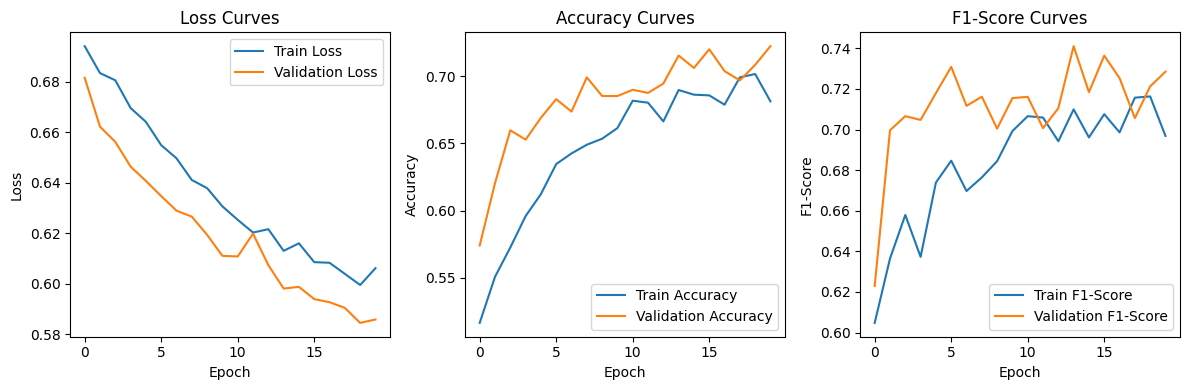

In [19]:
import matplotlib.pyplot as plt

# Assuming history_train and history_val are lists of tuples (loss, accuracy, f1_score)
train_losses, train_accuracies, train_f1s = zip(*history_train)
val_losses, val_accuracies, val_f1s = zip(*history_val)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(train_f1s, label='Train F1-Score')
plt.plot(val_f1s, label='Validation F1-Score')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('F1-Score Curves')
plt.legend()

plt.tight_layout()
plt.show()


In [22]:
model = models.efficientnet_b0(pretrained=True)  # Or efficientnet_b1/b2 if you want larger
# Replace classifier
model.classifier[1] = nn.Sequential(
    nn.Dropout(0.8),
    nn.Linear(model.classifier[1].in_features, 1)
)
model = model.to(device)


# --- LOSS + OPTIMIZER ---
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# --- METRICS ---
train_f1 = torchmetrics.classification.BinaryF1Score().to(device)
val_f1 = torchmetrics.classification.BinaryF1Score().to(device)
test_f1 = torchmetrics.classification.BinaryF1Score().to(device)

history_train = []
history_val = []


# --- TRAIN FUNCTION ---
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    global history_train, history_val

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        train_f1.reset()

        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Training", leave=False)
        for images, labels in loop:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            preds = torch.sigmoid(outputs)
            preds_class = (preds > 0.5).float()

            correct += (preds_class == labels).sum().item()
            total += labels.size(0)

            train_f1.update(preds_class, labels)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        epoch_f1_score = train_f1.compute().item()

        history_train.append((epoch_loss, epoch_acc, epoch_f1_score))
        # --- Validation ---
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        val_f1.reset()

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Validation", leave=False):
                images = images.to(device)
                labels = labels.float().unsqueeze(1).to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()

                preds = torch.sigmoid(outputs)
                preds_class = (preds > 0.5).float()

                val_correct += (preds_class == labels).sum().item()
                val_total += labels.size(0)

                val_f1.update(preds_class, labels)

        val_epoch_loss = val_loss / len(val_loader)
        val_epoch_acc = val_correct / val_total
        val_epoch_f1_score = val_f1.compute().item()
        history_val.append((val_epoch_loss, val_epoch_acc, val_epoch_f1_score))
        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | Train F1: {epoch_f1_score:.4f} || "
              f"Val Loss: {val_epoch_loss:.4f} | Val Acc: {val_epoch_acc:.4f} | Val F1: {val_epoch_f1_score:.4f}")

# --- TEST FUNCTION ---
def test(model, test_loader):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    test_f1.reset()

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing", leave=False):
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()

            preds = torch.sigmoid(outputs)
            preds_class = (preds > 0.5).float()

            correct += (preds_class == labels).sum().item()
            total += labels.size(0)

            test_f1.update(preds_class, labels)

    test_epoch_loss = test_loss / len(test_loader)
    test_epoch_acc = correct / total
    test_epoch_f1_score = test_f1.compute().item()

    print(f"Test Results -> Loss: {test_epoch_loss:.4f} | Accuracy: {test_epoch_acc:.4f} | F1 Score: {test_epoch_f1_score:.4f}")

# --- START TRAINING ---
train(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)

# --- START TESTING ---
test(model, test_loader)


Epoch [1/5] | Train Loss: 0.6817 | Train Acc: 0.5662 | Train F1: 0.6078 || Val Loss: 0.6623 | Val Acc: 0.5995 | Val F1: 0.5043


Epoch [2/5] | Train Loss: 0.6013 | Train Acc: 0.6802 | Train F1: 0.6990 || Val Loss: 0.5636 | Val Acc: 0.7176 | Val F1: 0.7371


Epoch [3/5] | Train Loss: 0.5153 | Train Acc: 0.7620 | Train F1: 0.7706 || Val Loss: 0.4866 | Val Acc: 0.7662 | Val F1: 0.7689


Epoch [4/5] | Train Loss: 0.4291 | Train Acc: 0.8215 | Train F1: 0.8263 || Val Loss: 0.4267 | Val Acc: 0.7940 | Val F1: 0.8018


Epoch [5/5] | Train Loss: 0.3122 | Train Acc: 0.8835 | Train F1: 0.8860 || Val Loss: 0.3792 | Val Acc: 0.8310 | Val F1: 0.8389


Test Results -> Loss: 0.3613 | Accuracy: 0.8522 | F1 Score: 0.8408


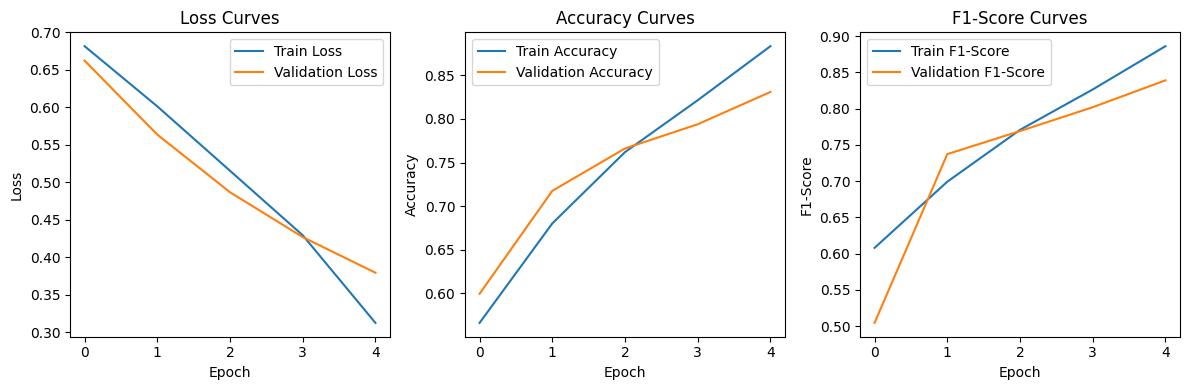

In [23]:
import matplotlib.pyplot as plt

# Assuming history_train and history_val are lists of tuples (loss, accuracy, f1_score)
train_losses, train_accuracies, train_f1s = zip(*history_train)
val_losses, val_accuracies, val_f1s = zip(*history_val)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(train_f1s, label='Train F1-Score')
plt.plot(val_f1s, label='Validation F1-Score')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('F1-Score Curves')
plt.legend()

plt.tight_layout()
plt.show()


# Training Vision Transformer B1 Pre-trained

In [18]:
import timm
from torch.optim.lr_scheduler import CosineAnnealingLR
# --- MODEL: TIMM Vision Transformer ---
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=1)
model = model.to(device)

# --- LOSS + OPTIMIZER ---
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
scheduler = CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

# --- METRICS ---
train_f1 = torchmetrics.classification.BinaryF1Score().to(device)
val_f1 = torchmetrics.classification.BinaryF1Score().to(device)
test_f1 = torchmetrics.classification.BinaryF1Score().to(device)

# --- TRAINING LOOP ---
num_epochs = 7
best_val_f1 = 0.0
patience = 5
counter = 0
best_model_path = "best_vit_model.pth"

vit_history_train = []
vit_history_val = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    train_f1.reset()

    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Training", leave=False)
    for images, labels in loop:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()

        running_loss += loss.item()
        preds = torch.sigmoid(outputs)
        preds_class = (preds > 0.5).float()

        correct += (preds_class == labels).sum().item()
        total += labels.size(0)
        train_f1.update(preds_class, labels)

    scheduler.step()  # Update learning rate

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    epoch_f1 = train_f1.compute().item()

    vit_history_train.append((epoch_loss, epoch_acc, epoch_f1))
    # --- VALIDATION ---
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    val_f1.reset()

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Validation", leave=False):
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = torch.sigmoid(outputs)
            preds_class = (preds > 0.5).float()

            val_correct += (preds_class == labels).sum().item()
            val_total += labels.size(0)
            val_f1.update(preds_class, labels)

    val_epoch_loss = val_loss / len(val_loader)
    val_epoch_acc = val_correct / val_total
    val_epoch_f1 = val_f1.compute().item()

    # --- Save best model ---
    if val_epoch_f1 > best_val_f1:
        best_val_f1 = val_epoch_f1
        torch.save(model.state_dict(), best_model_path)
        counter = 0
    else:
        counter += 1

    # --- Early stopping ---
    if counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    vit_history_val.append((val_epoch_loss, val_epoch_acc, val_epoch_f1))
    # --- TESTING ---
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    test_f1.reset()

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Testing", leave=False):
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            preds = torch.sigmoid(outputs)
            preds_class = (preds > 0.5).float()

            test_correct += (preds_class == labels).sum().item()
            test_total += labels.size(0)
            test_f1.update(preds_class, labels)

    test_epoch_loss = test_loss / len(test_loader)
    test_epoch_acc = test_correct / test_total
    test_epoch_f1 = test_f1.compute().item()

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | Train F1: {epoch_f1:.4f} || "
          f"Val Loss: {val_epoch_loss:.4f} | Val Acc: {val_epoch_acc:.4f} | Val F1: {val_epoch_f1:.4f} || "
          f"Test Loss: {test_epoch_loss:.4f} | Test Acc: {test_epoch_acc:.4f} | Test F1: {test_epoch_f1:.4f}")

# --- Load best model for final evaluation ---
model.load_state_dict(torch.load(best_model_path))
print(f"Loaded best model with Validation F1: {best_val_f1:.4f}")

Epoch [1/7] | Train Loss: 0.7851 | Train Acc: 0.5047 | Train F1: 0.5007 || Val Loss: 0.7028 | Val Acc: 0.5093 | Val F1: 0.6748 || Test Loss: 0.7208 | Test Acc: 0.4550 | Test F1: 0.6254


Epoch [2/7] | Train Loss: 0.7006 | Train Acc: 0.5498 | Train F1: 0.5505 || Val Loss: 0.6757 | Val Acc: 0.6042 | Val F1: 0.5341 || Test Loss: 0.6722 | Test Acc: 0.6097 | Test F1: 0.4955


Epoch [3/7] | Train Loss: 0.6623 | Train Acc: 0.5895 | Train F1: 0.5957 || Val Loss: 0.6786 | Val Acc: 0.5787 | Val F1: 0.4013 || Test Loss: 0.6537 | Test Acc: 0.6143 | Test F1: 0.3451


Epoch [4/7] | Train Loss: 0.6178 | Train Acc: 0.6668 | Train F1: 0.6643 || Val Loss: 0.6550 | Val Acc: 0.6458 | Val F1: 0.7311 || Test Loss: 0.6909 | Test Acc: 0.6143 | Test F1: 0.6795


Epoch [5/7] | Train Loss: 0.5557 | Train Acc: 0.7184 | Train F1: 0.7237 || Val Loss: 0.6891 | Val Acc: 0.6389 | Val F1: 0.7214 || Test Loss: 0.7146 | Test Acc: 0.6443 | Test F1: 0.6932


Epoch [6/7] | Train Loss: 0.5270 | Train Acc: 0.7610 | Train F1: 0.7683 || Val Loss: 0.6197 | Val Acc: 0.6574 | Val F1: 0.7075 || Test Loss: 0.6252 | Test Acc: 0.6882 | Test F1: 0.7134


<ipython-input-18-19c28abea18f>:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Epoch [7/7] | Train Loss: 0.4108 | Train Acc: 0.8260 | Train F1: 0.8292 || Val Loss: 0.5578 | Val Acc: 0.7153 | Val F1: 0.7355 || Test Loss: 0.5825 | Test Acc: 0.7344 | Test F1: 0.7368
Loaded best model with Validation F1: 0.7355


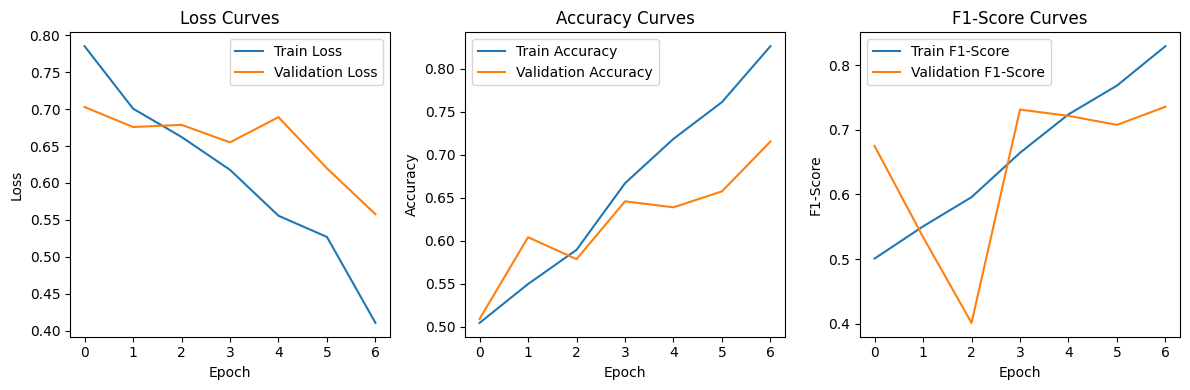

In [19]:
import matplotlib.pyplot as plt

# Assuming history_train and history_val are lists of tuples (loss, accuracy, f1_score)
train_losses, train_accuracies, train_f1s = zip(*vit_history_train)
val_losses, val_accuracies, val_f1s = zip(*vit_history_val)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(train_f1s, label='Train F1-Score')
plt.plot(val_f1s, label='Validation F1-Score')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('F1-Score Curves')
plt.legend()

plt.tight_layout()
plt.show()
